Author：Author: Ziyuan Li, 12211225
Date: 2024 Nov 30

This document is created as a report for SDM274, Sustech.

# 1. Preparing the data for fit


In [1]:
from nonlin import complex_nonlin_func
from modules import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Prepare the data for fitting
x = np.linspace(-10, 10, 500)
y = complex_nonlin_func(x)

# add noise to the data
y = y + 0.2 * np.random.normal(size=x.size)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)


In [2]:
def mse_loss(predicted, target):
    return np.mean((predicted - target) ** 2)

def mse_loss_grad(predicted, target):
    return 2 * (predicted - target) / len(target)


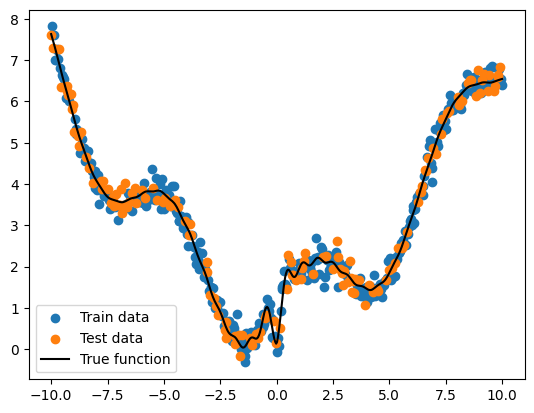

In [3]:
# plot the data

plt.scatter(X_train, y_train, label='Train data')
plt.scatter(X_test, y_test, label='Test data')
plt.plot(x, complex_nonlin_func(x), label='True function', color='black')
plt.legend()
plt.show()


# 2. Designing the MLP

In [4]:
# construct the MLP model

class MLP(Module):
    def __init__(self, layers, epochs=1000, lr=0.01, input_shape = 1, output_shape = 1):
        super().__init__()
        self.layers = layers
        self.epochs = epochs
        self.lr = lr
        self.loss = []
        self.input_shape = input_shape
        self.ouatput_shape = output_shape
        
        
    def forward(self, X):
        A = X  # input layer, caches the input
        for layer in self.layers[:-1]:
            A = layer.forward(A)
        # We leave the last layer out to compute the loss
        return A
    
    def backward(self, dA):
        dZ = dA 
        # again we externally call the last layer
        for layer in reversed(self.layers[:-1]):
            dZ = layer.backward(dZ)
            
        
    def update_params(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W -= lr * layer.parameters['dW']
                layer.b -= lr * layer.parameters['db']
                
    def train_BGD(self, X, Y, epochs=None, lr=None):
        if epochs is None:
            epochs = self.epochs
        if lr is None:
            lr = self.lr

        # expands X to (m, features) 
        # feature number here is coded in self.input_shape
        X = X.reshape(-1, self.input_shape)

        for epoch in range(epochs):
            
            # forward pass
            # it iterates all the layers except the last one
            A = self.forward(X)
            
            # compute the loss using the MSE layer
            loss = self.layers[-1].forward(A, Y)
            self.loss.append(loss)

            # backward pass using the MSE layer
            dA = self.layers[-1].backward(A, Y)
            self.backward(dA)
            
            # update the parameters
            self.update_params(lr)
            
            # Print loss every 50 epochs
            if epoch % 50 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
    
              
                

In [5]:
layers = [
    Linear(input_size=1, output_size=10),
    ReLU(),
    Linear(input_size=10, output_size=10),
    ReLU(),
    Linear(input_size=10, output_size=1),
    MSE()
]

# 3. Training the MLP Model

In [ ]:
mlp_model = MLP(layers, epochs=5000, lr=0.05)

# Train the model with the generated data
mlp_model.train_BGD(X_train, y_train)


Epoch 0, Loss: 13.675132206911083
Epoch 50, Loss: 13.36144523118946
Epoch 100, Loss: 13.064578363249506
Epoch 150, Loss: 12.778368148267052
Epoch 200, Loss: 12.50189179441797
Epoch 250, Loss: 12.234033376945233
Epoch 300, Loss: 11.974303459518476
Epoch 350, Loss: 11.722079768920752
Epoch 400, Loss: 11.47681018520902
Epoch 450, Loss: 11.237982525582767
Epoch 500, Loss: 11.00562535078544
Epoch 550, Loss: 10.77940631133973
Epoch 600, Loss: 10.558314347959918
Epoch 650, Loss: 10.341899664430125
Epoch 700, Loss: 10.129738347530683
Epoch 750, Loss: 9.921416751297642
Epoch 800, Loss: 9.716539832462923
Epoch 850, Loss: 9.514612615349634
Epoch 900, Loss: 9.31515062813605
Epoch 950, Loss: 9.11761365635307
Epoch 1000, Loss: 8.921426693204005
Epoch 1050, Loss: 8.725888390396943
Epoch 1100, Loss: 8.53030718131924
Epoch 1150, Loss: 8.334109467692524
Epoch 1200, Loss: 8.136772162555571
Epoch 1250, Loss: 7.937770097600997
Epoch 1300, Loss: 7.736726812225783
Epoch 1350, Loss: 7.533548610884281
Epoch 14

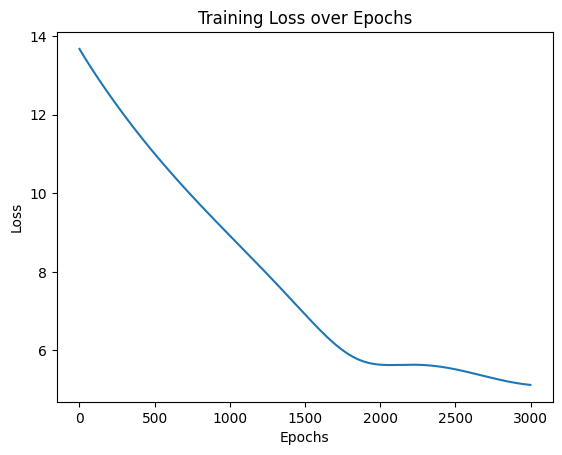

In [7]:
plt.plot(mlp_model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()